In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
import os.path
import pandas as pd
from PIL import Image
import sklearn
import scipy.spatial
import scipy.stats

In [4]:
def prep_data(data):
    idx = pd.MultiIndex.from_tuples(
        [(x.partition('/')[0], x.split('/')[1], '/'.join(x.split('/')[1:3]), x.rpartition('/')[2]) 
         for x in data.columns], 
        names=['category', 'user', 'board', 'image'])
    
    # scale the data
    data = data.T.set_index(idx).sort_index()
    #data = pd.DataFrame(sklearn.preprocessing.scale(data), index=data.index, columns=data.columns)
    return data

In [5]:
def get_colors(data, level, cmap='gist_rainbow'):
    values = data.index.get_level_values(level)
    value_set = set(values)
    value_map = {b:val/len(value_set) for b, val in zip(value_set, np.arange(float(len(value_set))))}
    cmap = cm.get_cmap(cmap)
    return cmap([value_map[x] for x in values])

In [6]:
def plot_images(fig, data, n_images=10, imsize=70, base_dir='/data/neon/customer_images/pinterest/intl_fashion'):
    data_sample = data.sample(n_images, axis=0)
    for i in range(n_images):
        row = data_sample.ix[i,:]
        try:
            im = Image.open(os.path.join(base_dir,
                                         data_sample.index.get_level_values('category')[i],
                                         data_sample.index.get_level_values('board')[i],
                                         data_sample.index.get_level_values('image')[i]))
        
            im.thumbnail((imsize, imsize))
        except IOError:
            continue
        imbox = OffsetImage(im)
        fig.get_axes()[0].add_artist(AnnotationBbox(imbox, row[:2], xycoords='data', frameon=False,
                                                    pad=0.0, box_alignment=(0.5, 0.5)))

In [178]:
fashion_features = pd.read_pickle('/data/neon/customer_images/pinterest/intl_fashion/intl_fashion_valence.pkl')
fashion_features = prep_data(fashion_features)

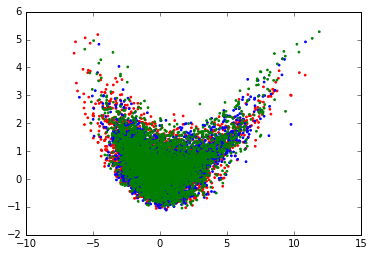

In [28]:
colors = ['r', 'g', 'b']
categories = fashion_features.index.get_level_values('category')
category_color = {cat: c for c, cat in zip(colors, set(categories))}
clrs = [category_color[x] for x in categories]
plt.scatter(fashion_features.ix[:,0], fashion_features.ix[:,1], color=clrs, s=3.)

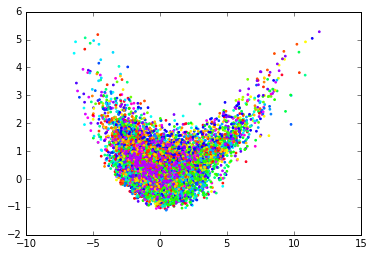

In [143]:
plt.scatter(fashion_features.ix[:,0], fashion_features.ix[:,1],
            color=get_colors(fashion_features, 'board'), s=3.)

In [7]:
def plot_images_evenly_in_space(features, base_dir=None):
    '''Plot the images to show so that we have roughly one in the middle of each grid cell'''
    fig = plt.figure(1, (15.0, 10.))
    plt.scatter(features.iloc[:,0], features.iloc[:,1])
    lim = fig.get_axes()[0].viewLim
    
    xrange = np.linspace(lim.xmin, lim.xmax, 24)
    yrange = np.linspace(lim.ymin, lim.ymax, 20)
    selected_features = []
    for x1, x2 in zip(xrange[:-1], xrange[1:]):
        for y1, y2 in zip(yrange[:-1], yrange[1:]):
            images_in_cell = ((features.iloc[:,0] > x1) & (features.iloc[:,0] < x2) & 
                              (features.iloc[:,1] > y1) & (features.iloc[:,1] < y2))
            images_in_cell = features.ix[images_in_cell]
            if images_in_cell.shape[0] == 0:
                continue
            selected_features.append(((images_in_cell.iloc[:,0] - ((x2+x1)/2)).abs() + 
                                      (images_in_cell.iloc[:,1] - (y1+y2)/2).abs()).argmin())
    images_to_show = features.ix[selected_features]
    plot_images(fig, images_to_show, n_images=images_to_show.shape[0], base_dir=base_dir)
    

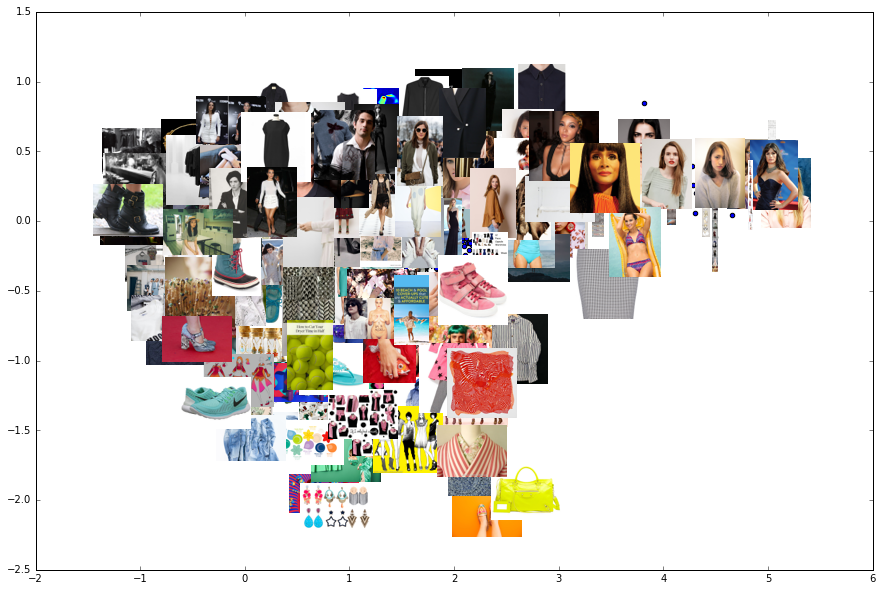

In [247]:
plot_images_evenly_in_space(fashion_features.ix[:,1:])
        

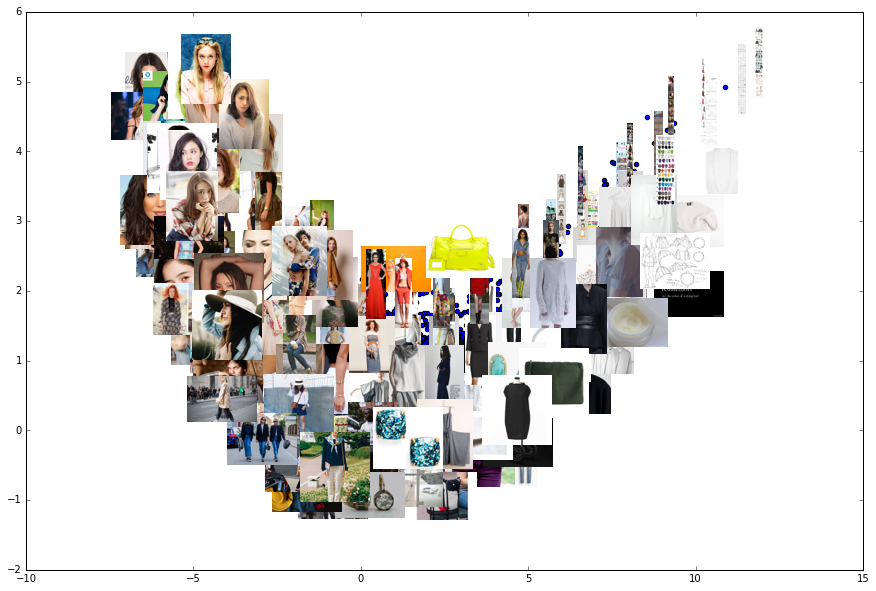

In [250]:
plot_images_evenly_in_space(fashion_features)

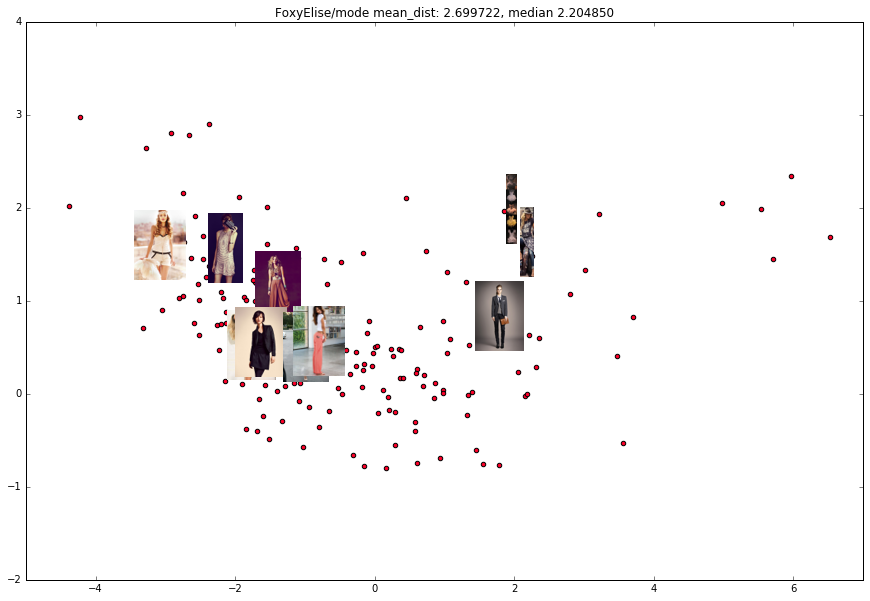

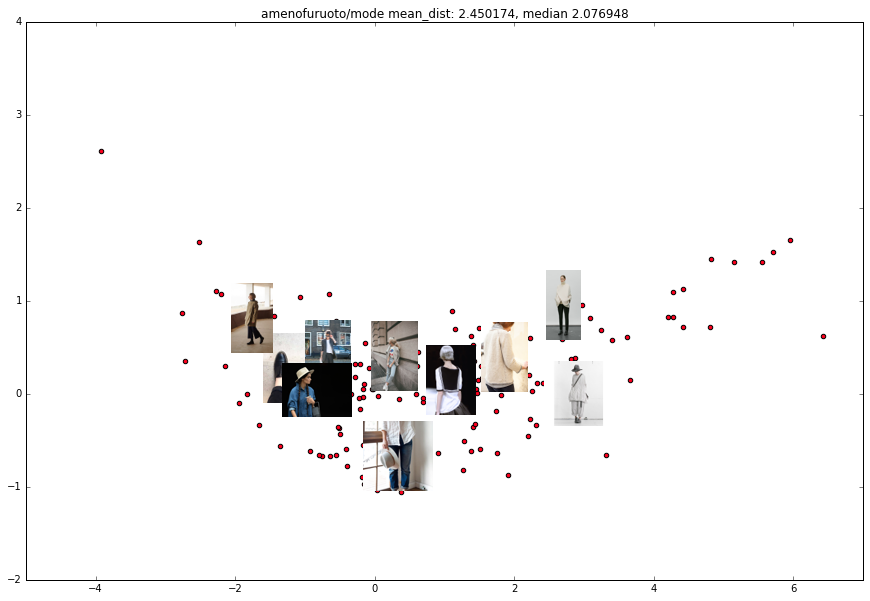

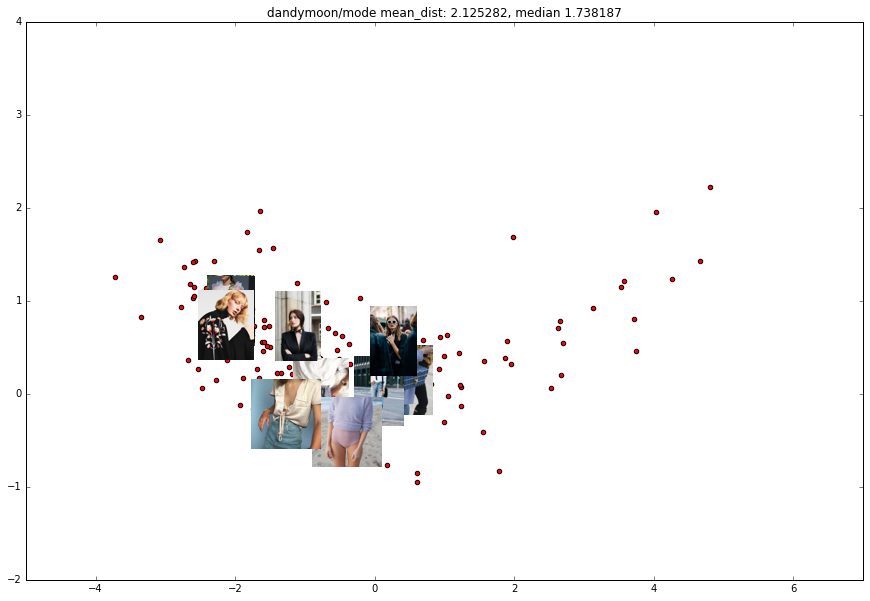

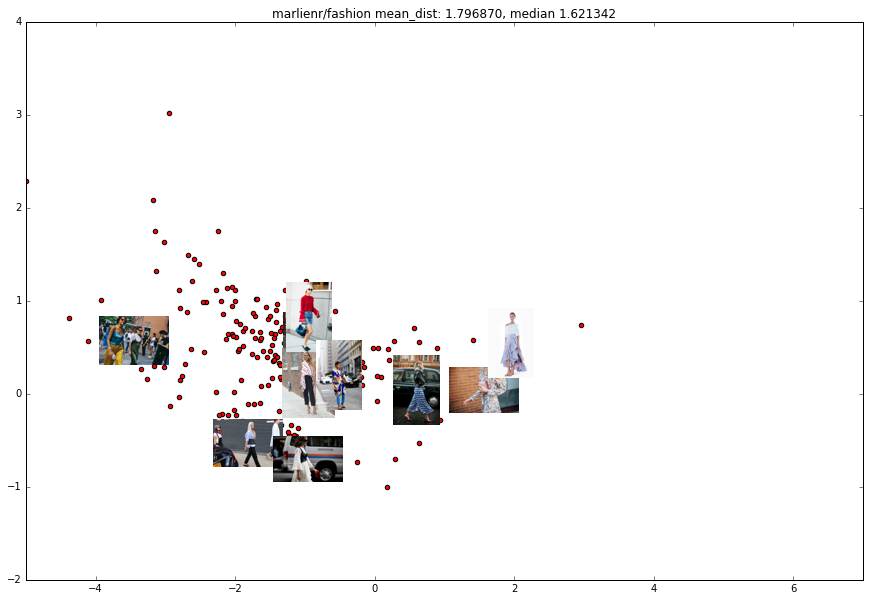

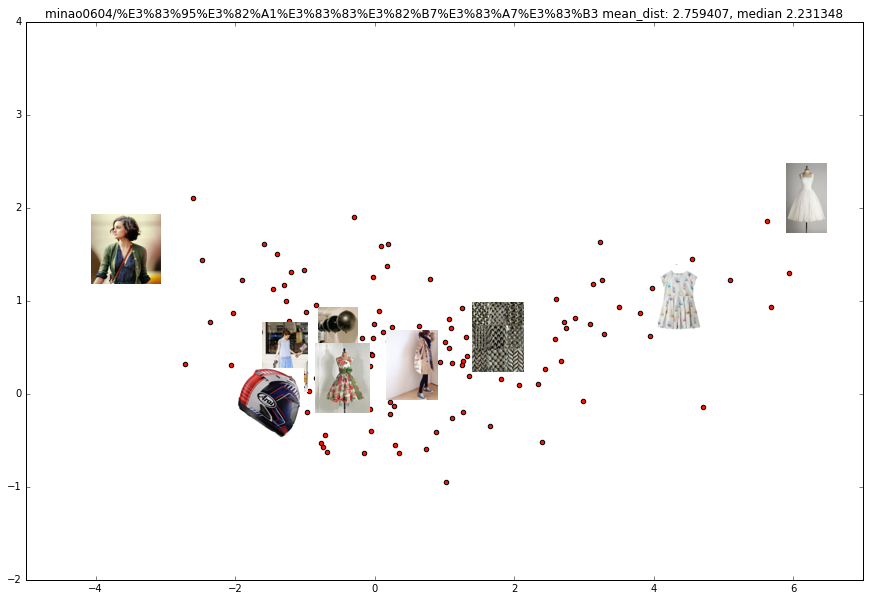

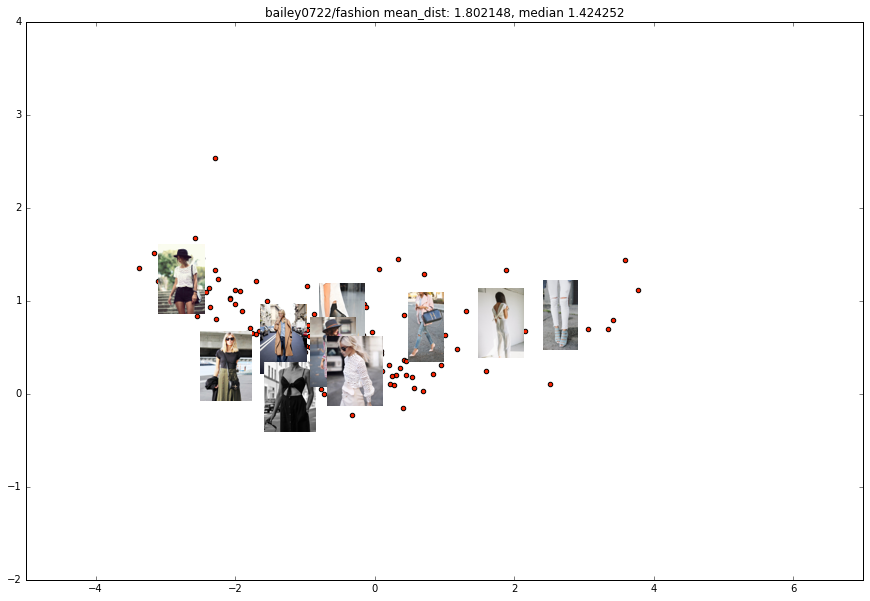

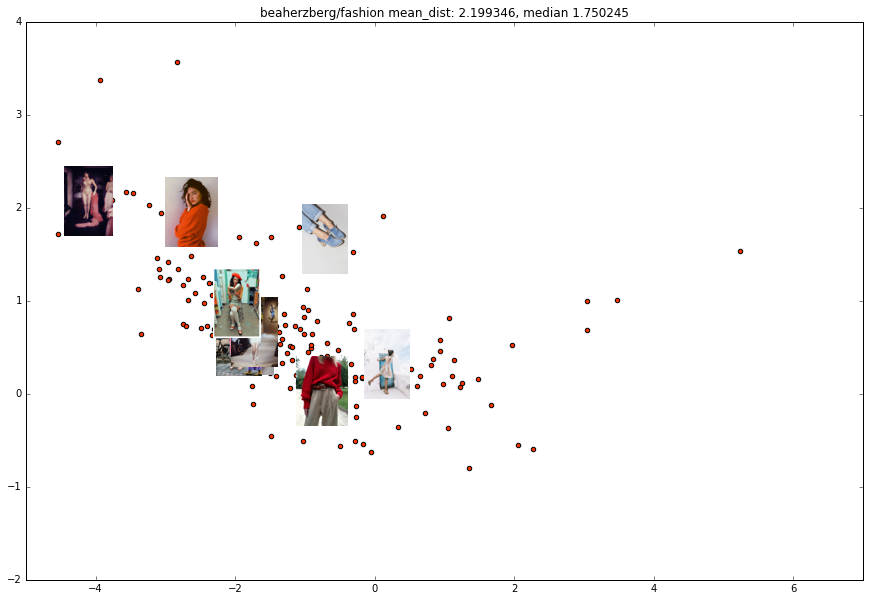

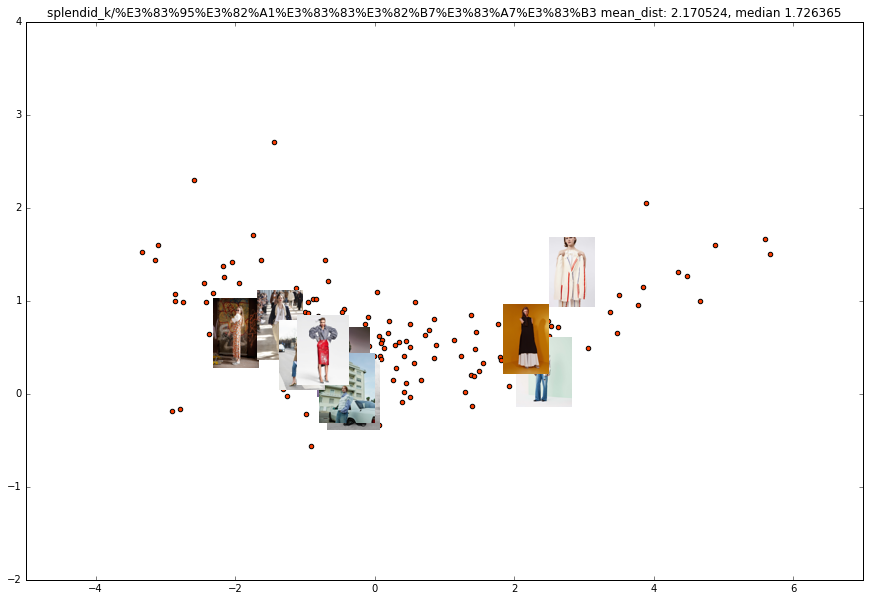

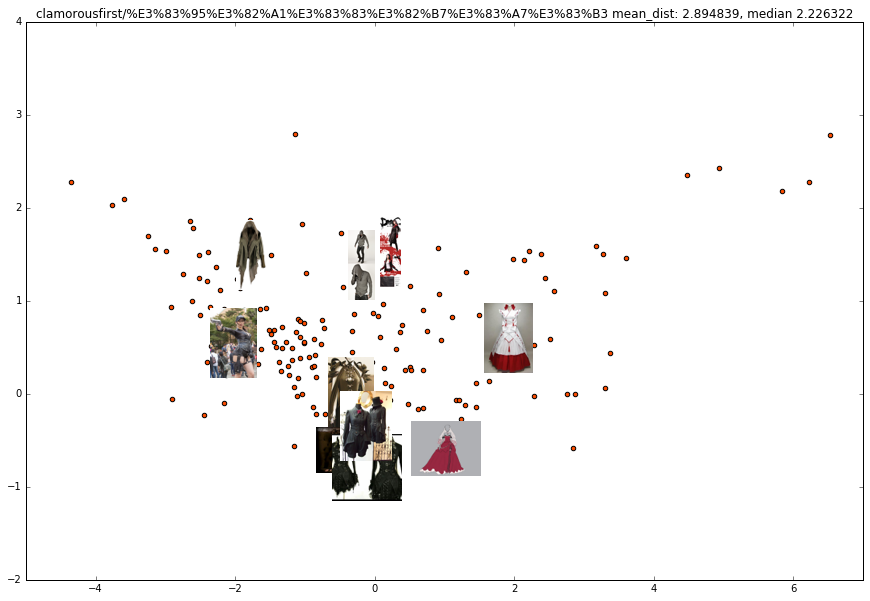

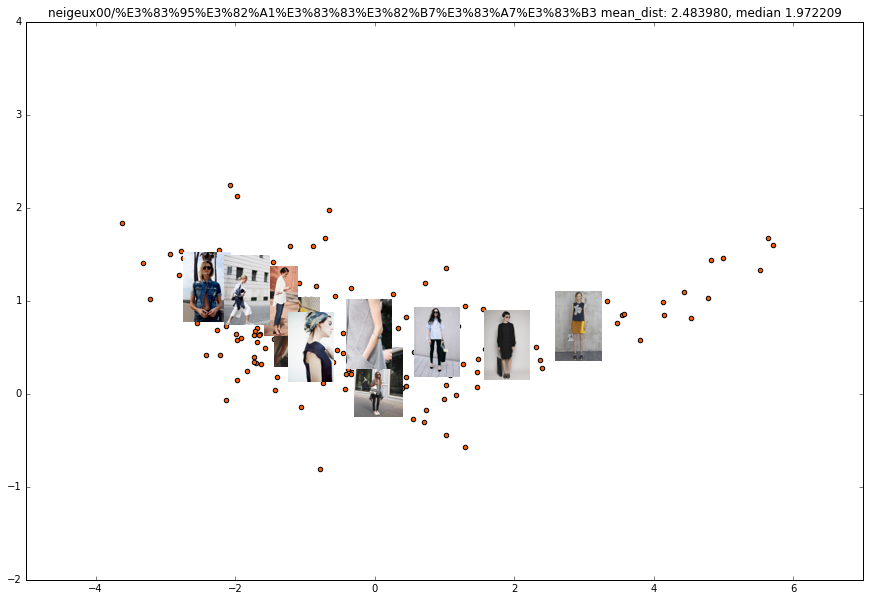

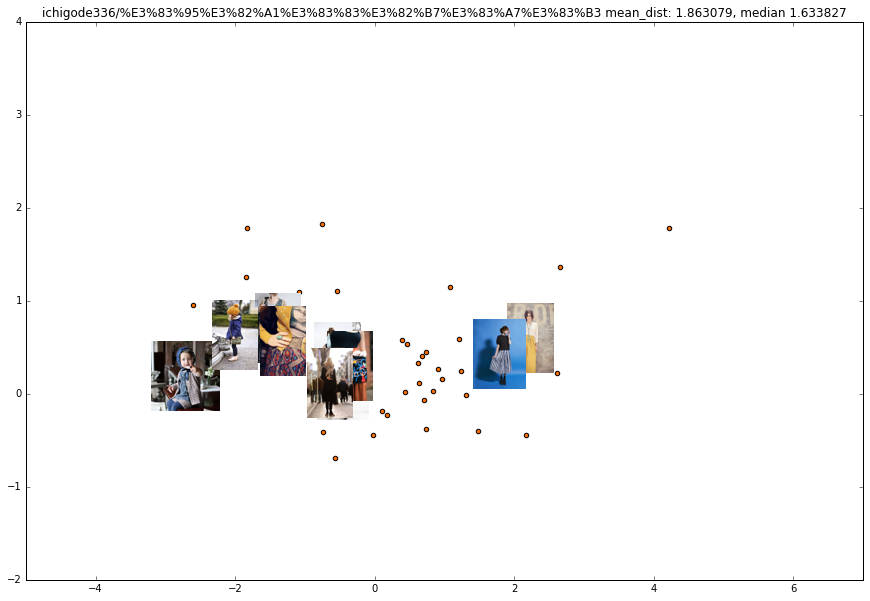

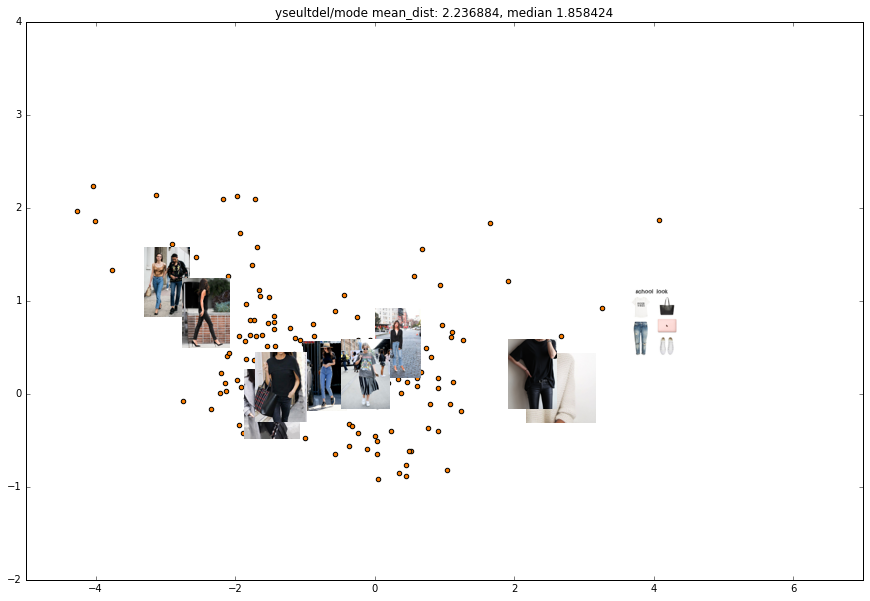

In [234]:
cmap = cm.get_cmap('gist_rainbow')
boards = fashion_features.index.get_level_values('board')
board_set = set(boards)
board_map = {b:val/len(board_set) for b, val in zip(board_set, np.arange(float(len(board_set))))}
board_clrs = cmap([board_map[x] for x in boards])
for board,i in zip(board_set, range(len(board_set))):
    data = fashion_features.xs(board, level='board', drop_level=False)
    fig = plt.figure(i, (15.0, 10.)) 
    plt.xlim([-5., 7.])
    plt.ylim([-2., 4.]) 
    plt.scatter(data.ix[:,0], data.ix[:,1], c=cmap(board_map[board]))
    plot_images(fig, data)
    dist_pairs = scipy.spatial.distance.pdist(data)
    plt.title('%s mean_dist: %f, median %f' % (board, np.mean(dist_pairs), np.median(dist_pairs)))
    if i > 10:
        break
#plt.scatter(fashion_features.ix[:,0], fashion_features.ix[:,1], color=board_clrs, s=3.)


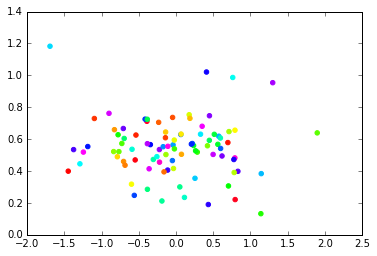

In [182]:
mn_boards = fashion_features.groupby(level=['category', 'user', 'board']).mean()
plt.scatter(mn_boards.ix[:,0], mn_boards.ix[:,1], color=get_colors(mn_boards, 'board'))

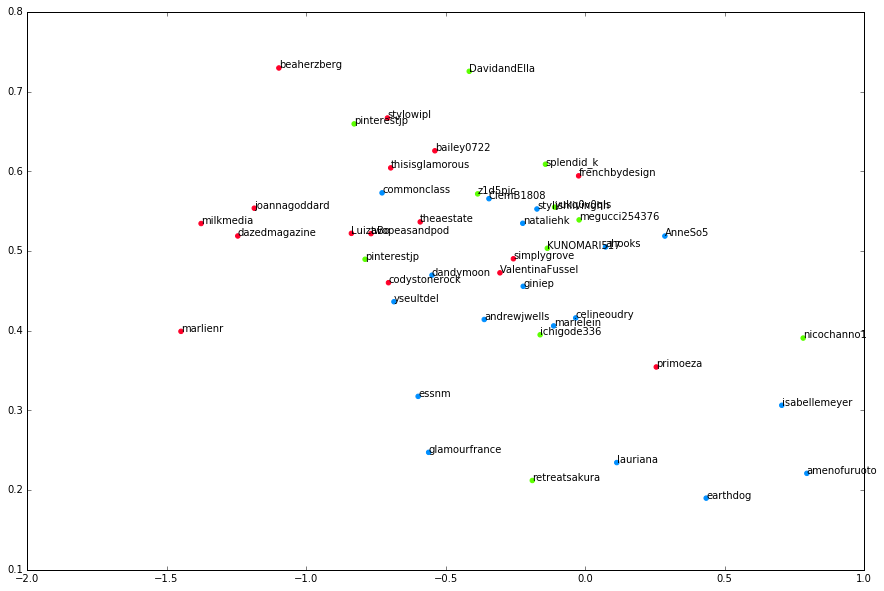

In [190]:
plt.figure(1, (15.0, 10.))
mn_boards = fashion_features.groupby(level=['category', 'user', 'board']).mean()
var_boards = fashion_features.groupby(level=['category', 'user', 'board']).var()
var_boards = var_boards.ix[:,0] + var_boards.ix[:,1]
chosen_boards = var_boards < var_boards.median()
mn_boards = mn_boards[chosen_boards]
plt.scatter(mn_boards.ix[:,0], mn_boards.ix[:,1], color=get_colors(mn_boards, 'category'))
for key, row in mn_boards.iterrows():
    plt.annotate(key[1], xy=row[0:2])

In [252]:
cakebath_features = pd.read_pickle('/data/neon/customer_images/pinterest/cross_reference_cake_bathroom/cake_bathrooms_valence.pkl')
cakebath_features = prep_data(cakebath_features)

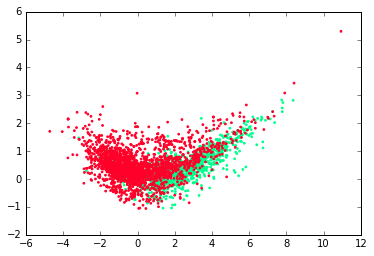

In [147]:
features = cakebath_features
plt.scatter(features.ix[:,0], features.ix[:,1],
            color=get_colors(features, 'category'), s=3.)

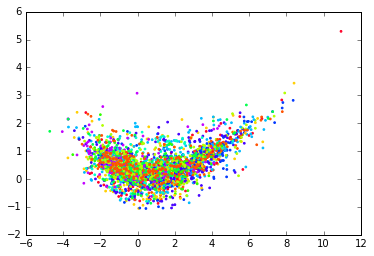

In [148]:
features = cakebath_features
plt.scatter(features.ix[:,0], features.ix[:,1],
            color=get_colors(features, 'user'), s=3.)

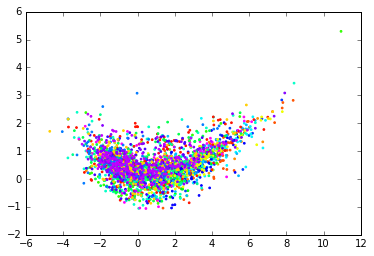

In [149]:
features = cakebath_features
plt.scatter(features.ix[:,0], features.ix[:,1],
            color=get_colors(features, 'board'), s=3.)

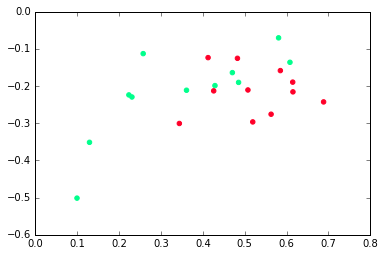

In [164]:
mn_boards = cakebath_features.groupby(level=['category', 'user', 'board']).mean()
plt.scatter(mn_boards.ix[:,1], mn_boards.ix[:,2], color=get_colors(mn_boards, 'category'))

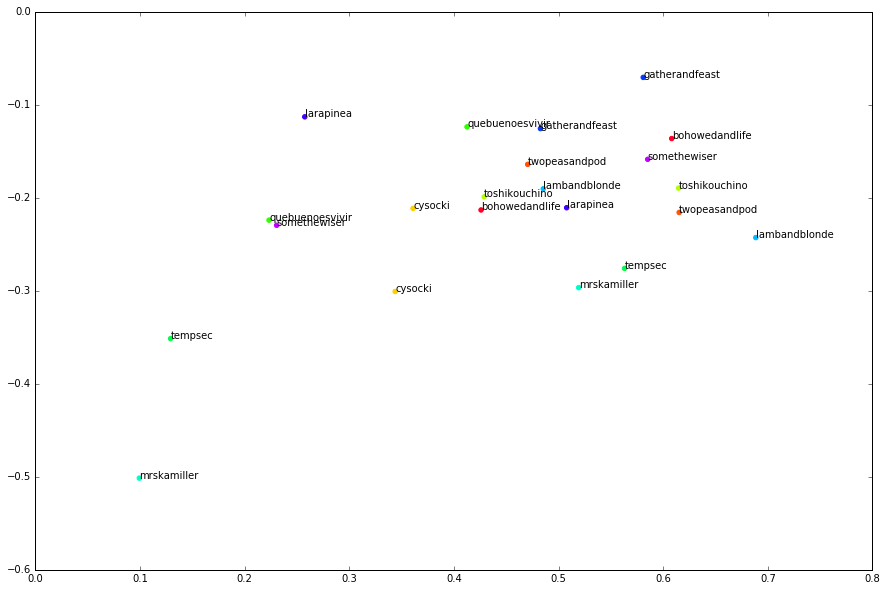

In [169]:
plt.figure(i, (15.0, 10.))
plt.scatter(mn_boards.ix[:,1], mn_boards.ix[:,2], color=get_colors(mn_boards, 'user'))
for key, row in mn_boards.iterrows():
    plt.annotate(key[1], xy=row[1:3])

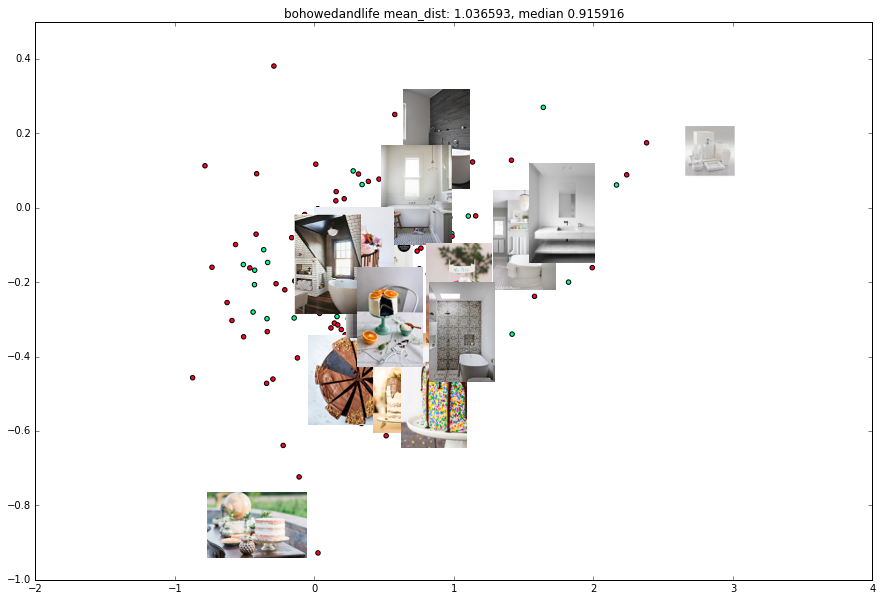

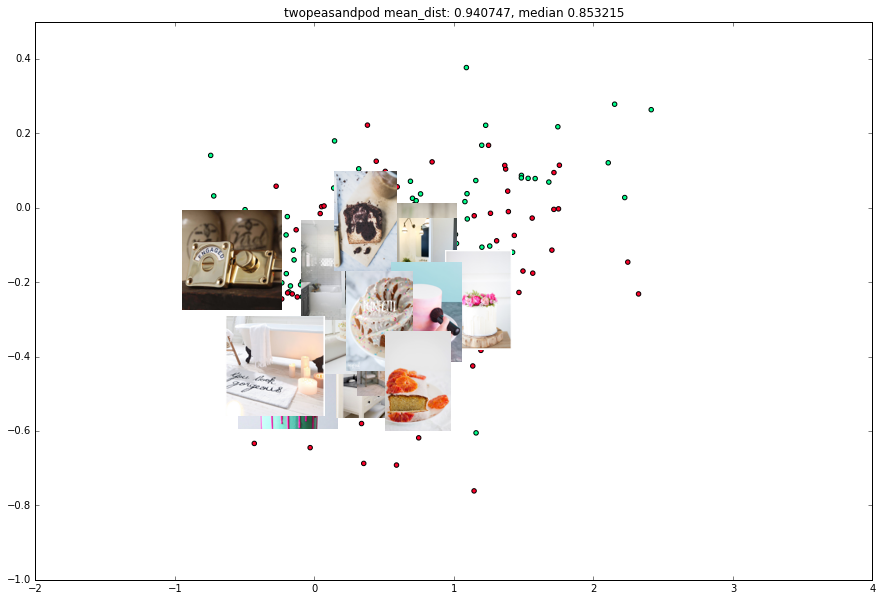

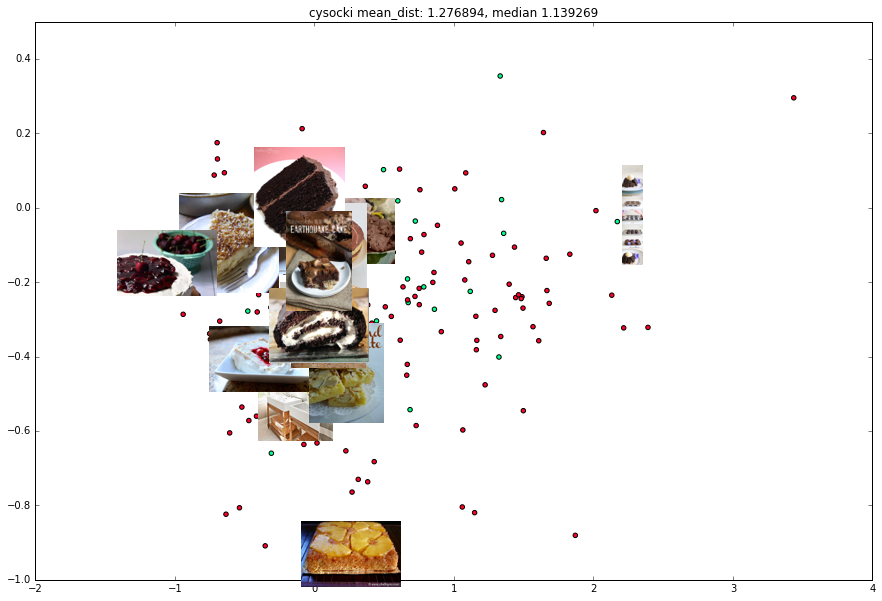

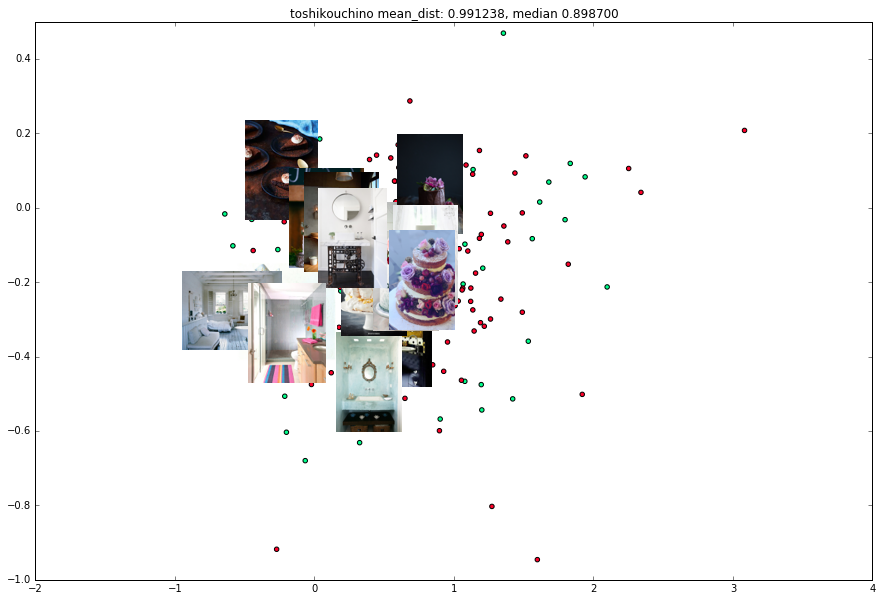

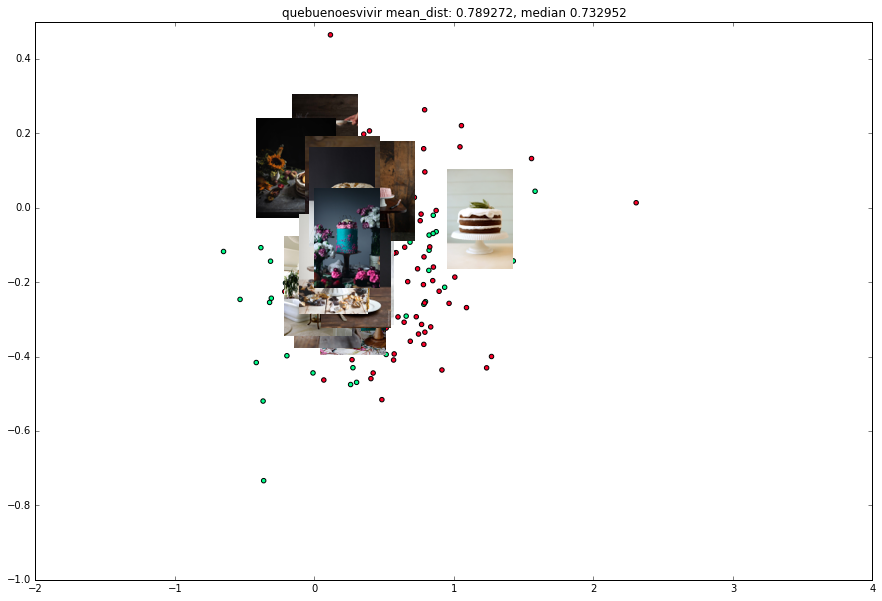

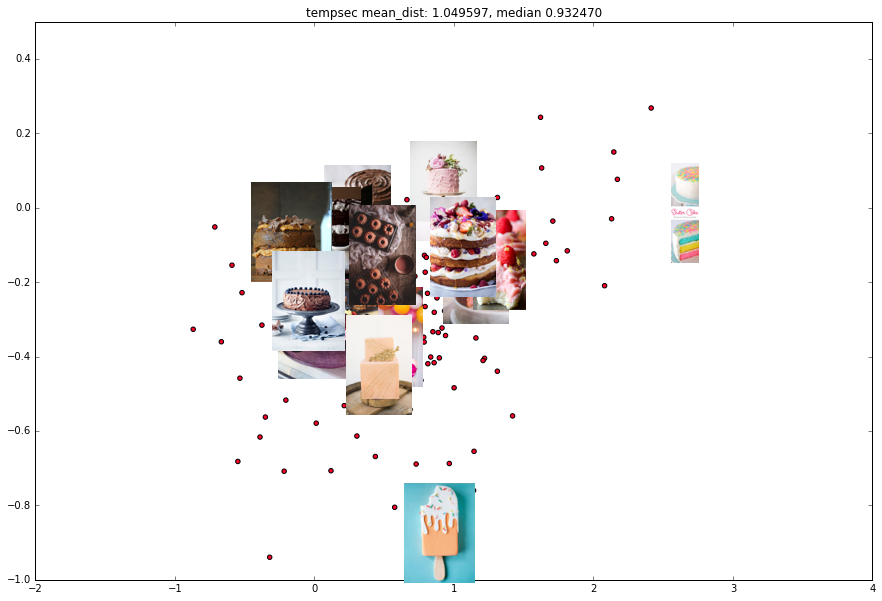

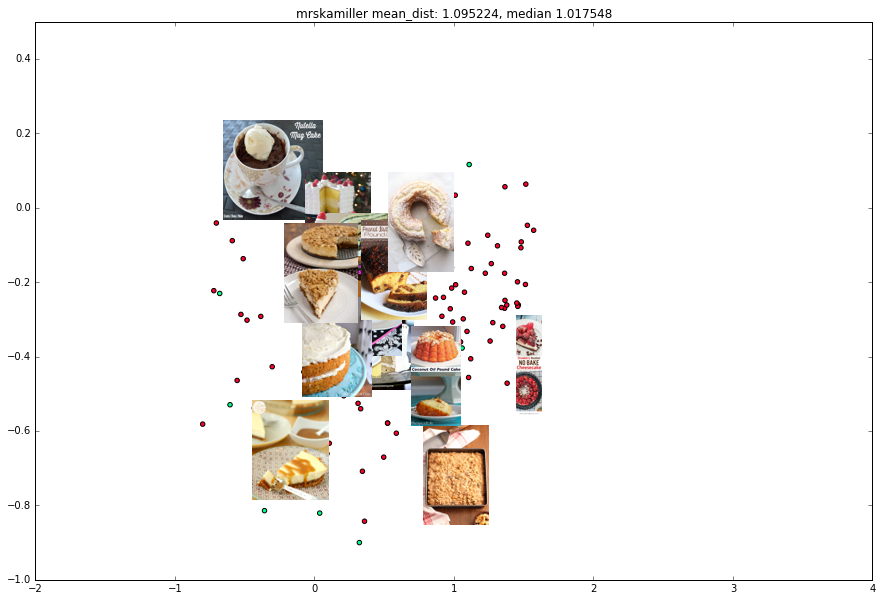

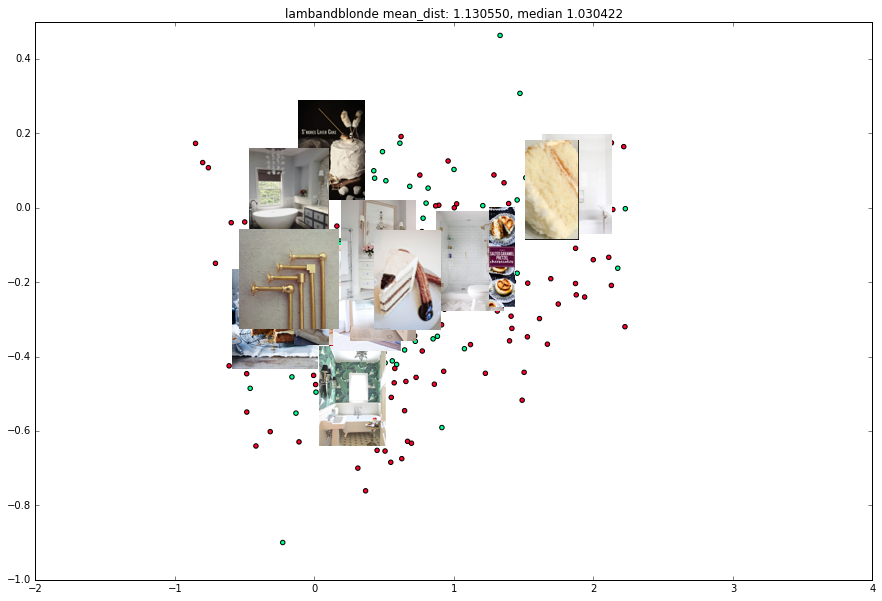

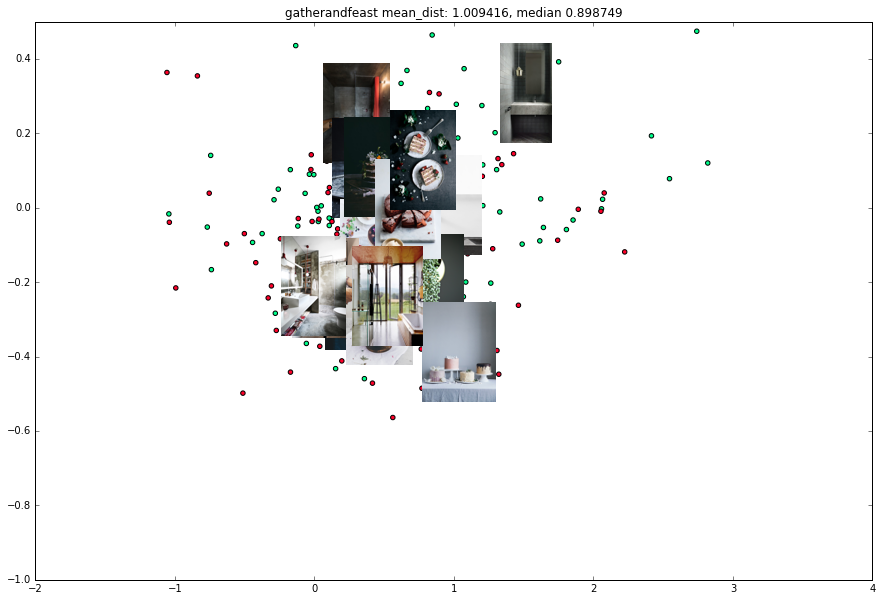

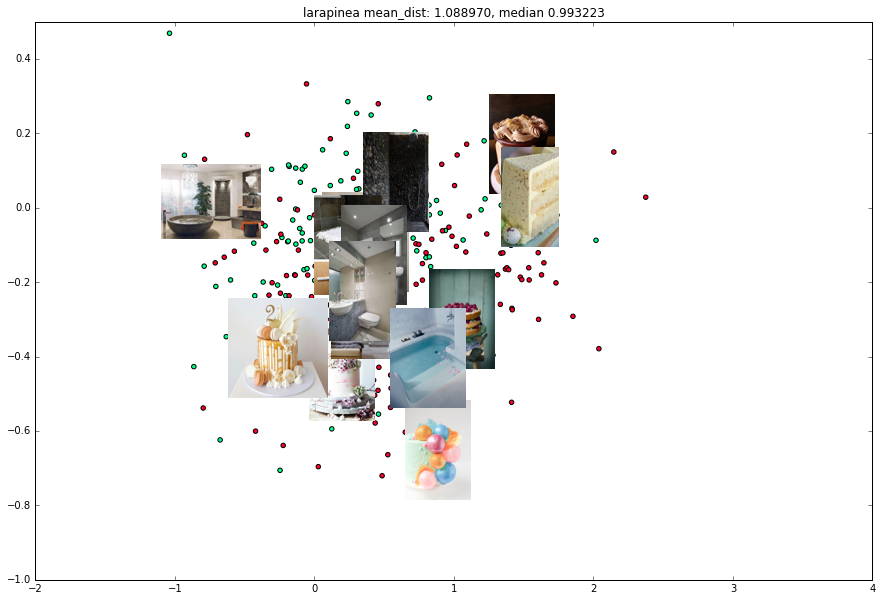

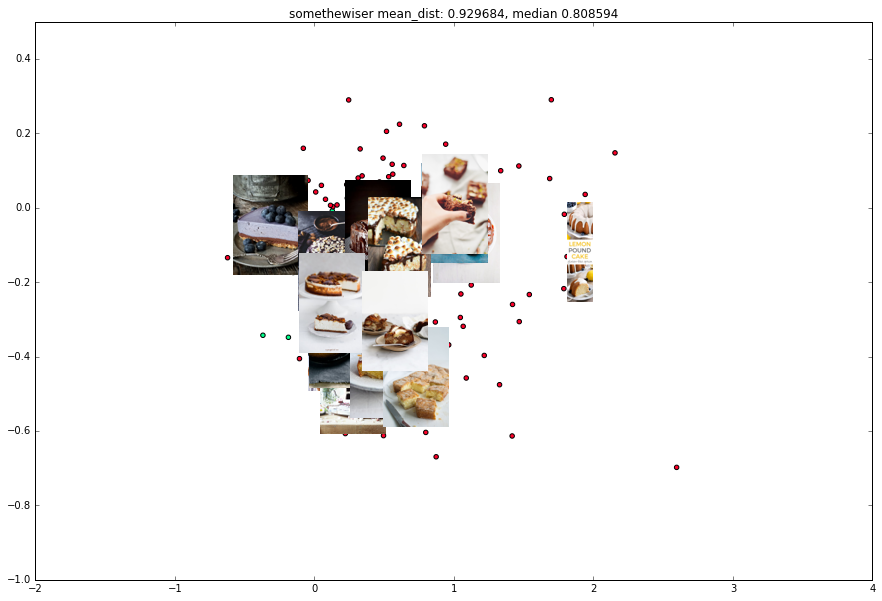

In [260]:
features = cakebath_features.ix[:,1:]
users = features.index.get_level_values('user')
user_set = set(users)
for user,i in zip(user_set, range(len(user_set))):
    data = features.xs(user, level='user', drop_level=False)
    fig = plt.figure(i, (15.0, 10.)) 
    plt.xlim([-2., 4.])
    plt.ylim([-1., .5]) 
    plt.scatter(data.iloc[:,0], data.iloc[:,1], c=get_colors(data, 'category'))
    plot_images(fig, data, n_images=15, imsize=100,
                base_dir='/data/neon/customer_images/pinterest/cross_reference_cake_bathroom') 
    dist_pairs = scipy.spatial.distance.pdist(data)
    plt.title('%s mean_dist: %f, median %f' % (user, np.mean(dist_pairs), np.median(dist_pairs)))

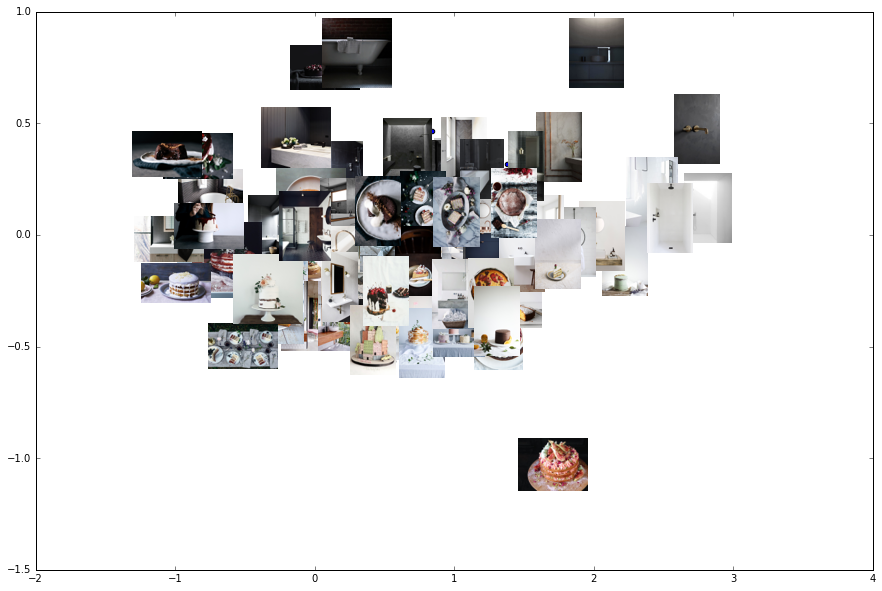

In [257]:
plot_images_evenly_in_space(cakebath_features.xs('gatherandfeast', level='user').iloc[:,1:],
                            base_dir='/data/neon/customer_images/pinterest/cross_reference_cake_bathroom')

In [9]:
nursekitchen_features = pd.read_pickle('/data/neon/customer_images/pinterest/cross_reference_nursery_kitchen/nursery_kitchen_valence.pkl')
nursekitchen_features = prep_data(nursekitchen_features)

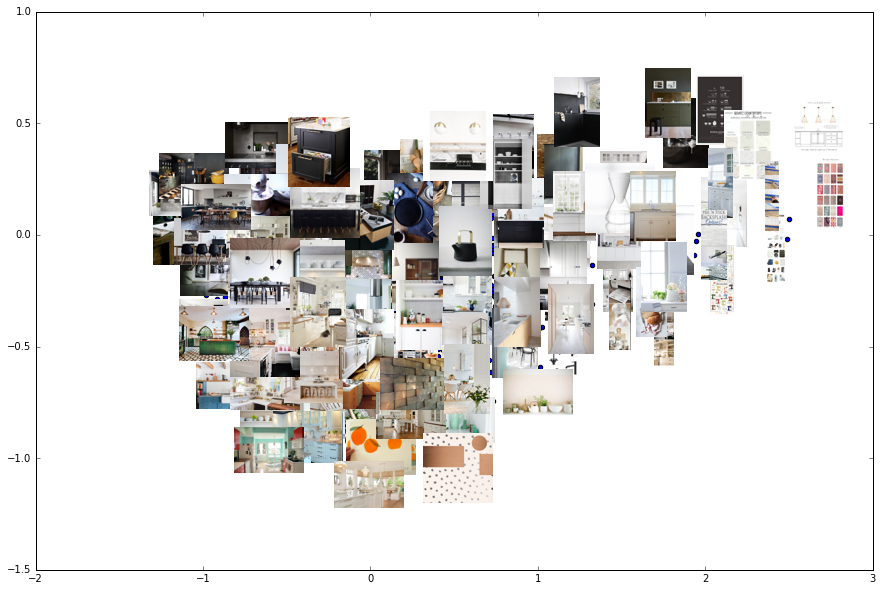

In [22]:
plot_images_evenly_in_space(nursekitchen_features.xs('kitchen', level='category', drop_level=False).iloc[:,1:],
                            base_dir='/data/neon/customer_images/pinterest/cross_reference_nursery_kitchen')
plt.xlim([-2., 3.])
plt.ylim([-1.5, 1.0])
plt.savefig("/data/neon/customer_images/pinterest/cross_reference_nursery_kitchen/dims2_3_kitchen.png", bbox_inches='tight')

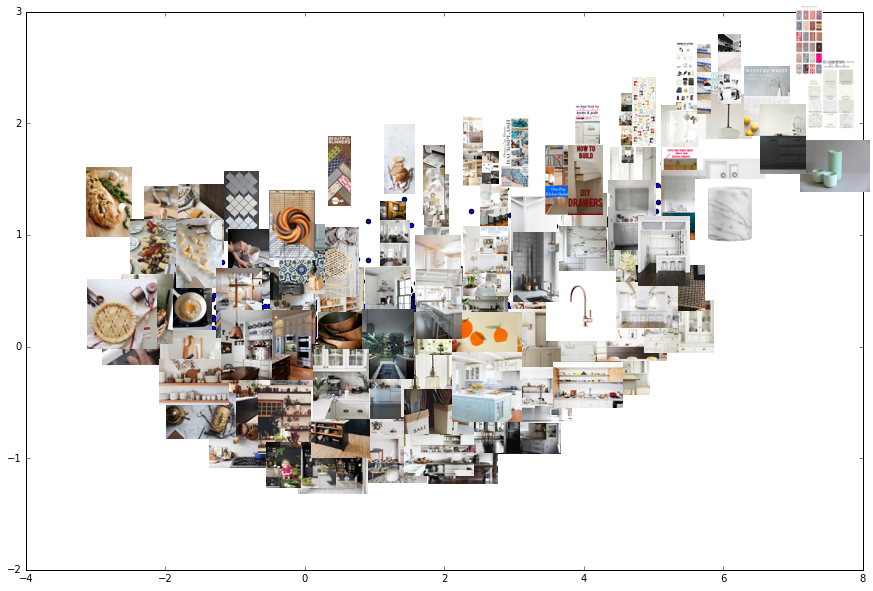

In [21]:
plot_images_evenly_in_space(nursekitchen_features.xs('kitchen', level='category', drop_level=False),
                            base_dir='/data/neon/customer_images/pinterest/cross_reference_nursery_kitchen')
plt.xlim([-4., 8.])
plt.ylim([-2, 3.])
plt.savefig("/data/neon/customer_images/pinterest/cross_reference_nursery_kitchen/dims1_2_kitchen.png", bbox_inches='tight')

In [23]:
set(nursekitchen_features.xs('kitchen', level='category', drop_level=False).index.get_level_values('board'))

{'DIYdecorideas/kitchen',
 'Foreverwildchld/kitchen',
 'Stonesegrist/kitchen',
 'VictoriousVii/kitchen',
 'apettyquarrel/kitchen',
 'aptapothecary/kitchen',
 'calivintage/kitchen',
 'holycute1/kitchen',
 'jadephl/kitchen',
 'jujupapers/kitchen',
 'ninamoore/kitchen',
 'plumprettysugar/kitchen',
 'rutepresado/kitchen',
 'spearmintbaby/kitchen',
 'sueprado/kitchen',
 'turbulencesdeco/kitchen'}